# Plot Fairfax eQTLs that overlapped with Neanderthal dataset
This code plots the expression data of monocyte extreme response peak eQTLs from Fairfax *et al.* for which the same variant has been identified as a Neanderthal-introgressed by Dannemann *et al.* and/or Simonti *et al*. Monocytes in the Fairfax dataset were divided into 4 treatment groups: IFN, LPS 2h, LPS 24h and Naive.

Neanderthal SNPs from:
1. Dannemann M, Prufer K & Kelso J. Functional implications of Neandertal introgression in modern humans. Genome Biol 2017 18:61.
2. Simonti CN *et al*. The phenotypic legacy of admixture between modern humans and Neandertals. Science 2016 351:737-41.

Monocyte extreme response peak eQTLs from:
1. Fairfax BP *et al*. Innate immune activity conditions the effect of regulatory variants upon monocyte gene expression. Science 2014 343:1246949.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import isnan
from plinkio import plinkfile

### Load datasets

In [2]:
# Load genotype data
plink_file = plinkfile.open("extreme_response/extreme_response")
sample_list = plink_file.get_samples()
locus_list = plink_file.get_loci()

In [3]:
# Load expression data
expr_info = pd.read_csv('expression_info.csv', index_col=0)
expr_Naive = pd.read_csv('all_expression_CD14.csv', index_col=0)
expr_IFN = pd.read_csv('all_expression_IFN.csv', index_col=0)
expr_LPS2 = pd.read_csv('all_expression_LPS2.csv', index_col=0)
expr_LPS24 = pd.read_csv('all_expression_LPS24.csv', index_col=0)

In [4]:
# Intersecting SNPs in Neanderthal & Fairfax datasets
comparison_df = pd.read_csv("../neanderthal/allpop_df.csv", usecols=['Chromosome', 'Position', 'Source', 'Major'])
extr_resp = pd.read_csv("tab2_a_cis_eSNPs.txt", sep="\t",
                        usecols=["SNP", "Gene", "SNP.Chrm", "SNP.pos", "Min.dataset", "LPS2.p.value", "LPS24.p.value",
                                 "IFN.p.value", "Naive.p.value", "LPS2.FDR", "LPS24.FDR", "IFN.FDR", "Naive.FDR"])
extr_resp = extr_resp.rename(columns={"SNP.Chrm": "Chromosome", "SNP.pos": "Position", "SNP": "ID"})
extr_resp_df = comparison_df.merge(extr_resp, how='left', on=['Chromosome', 'Position'])
extr_resp_df = extr_resp_df.dropna(subset=['ID'])

In [5]:
# Subset intersecting SNPs by treatment groups
# IFN
ifn = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "IFN"].copy()
ifn.drop(columns=["LPS2.p.value", "LPS24.p.value", "Naive.p.value", "LPS2.FDR", "LPS24.FDR", "Naive.FDR"], inplace=True)
ifn.rename(columns={"IFN.p.value": "p.value", "IFN.FDR": "FDR"}, inplace=True)
ifn = ifn.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

# LPS2
lps2 = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "LPS2"].copy()
lps2.drop(columns=["IFN.p.value", "LPS24.p.value", "Naive.p.value", "IFN.FDR", "LPS24.FDR", "Naive.FDR"], inplace=True)
lps2.rename(columns={"LPS2.p.value": "p.value", "LPS2.FDR": "FDR"}, inplace=True)
lps2 = lps2.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

# LPS24
lps24 = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "LPS24"].copy()
lps24.drop(columns=["LPS2.p.value", "IFN.p.value", "Naive.p.value", "LPS2.FDR", "IFN.FDR", "Naive.FDR"], inplace=True)
lps24.rename(columns={"LPS24.p.value": "p.value", "LPS24.FDR": "FDR"}, inplace=True)
lps24 = lps24.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

# Naive
naive = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "Naive"].copy()
naive.drop(columns=["LPS2.p.value", "LPS24.p.value", "IFN.p.value", "LPS2.FDR", "LPS24.FDR", "IFN.FDR"], inplace=True)
naive.rename(columns={"Naive.p.value": "p.value", "Naive.FDR": "FDR"}, inplace=True)
naive = naive.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

### eQTL plots

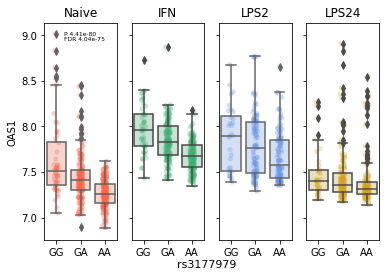

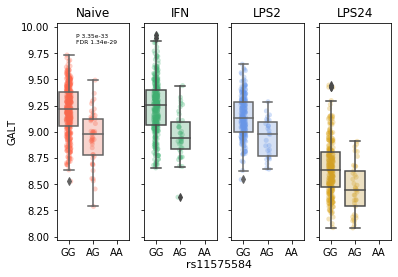

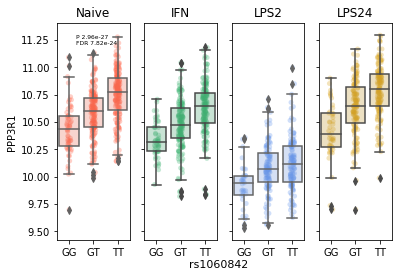

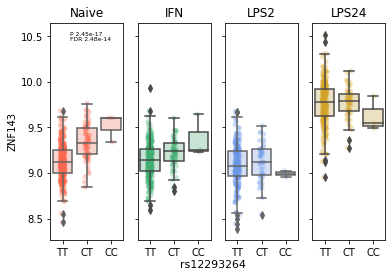

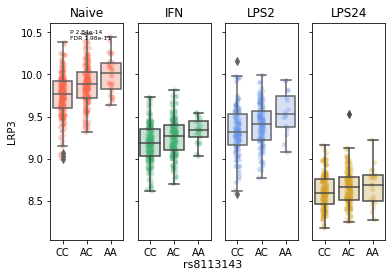

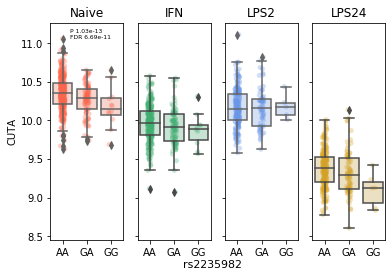

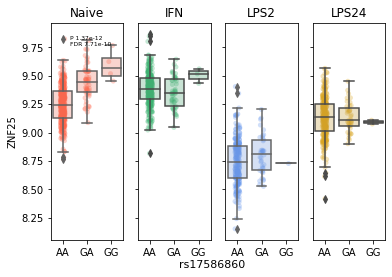

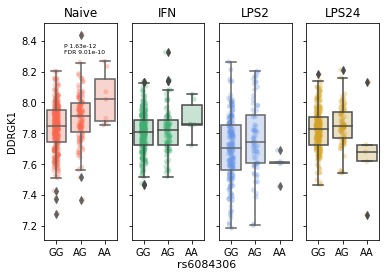

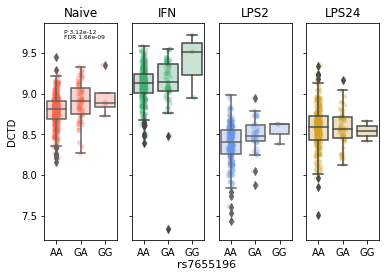

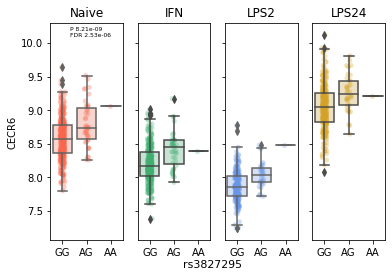

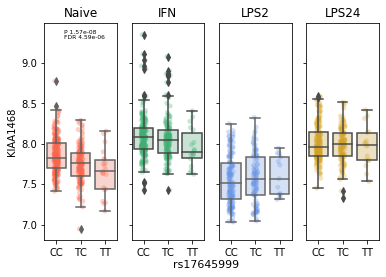

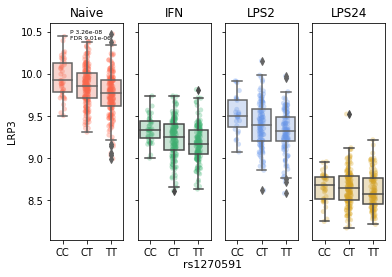

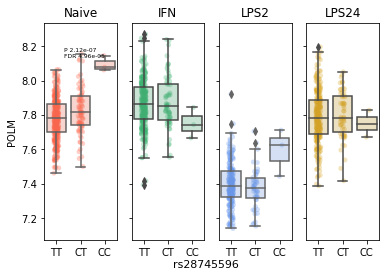

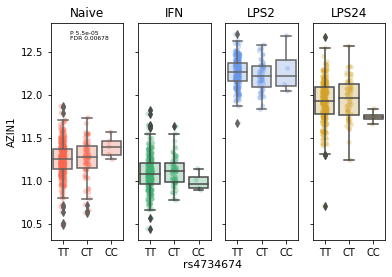

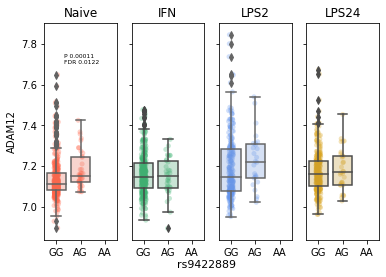

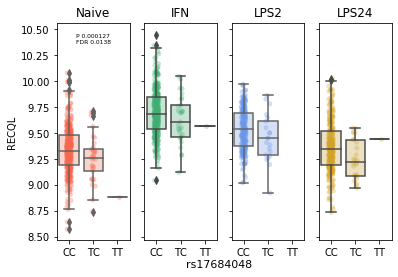

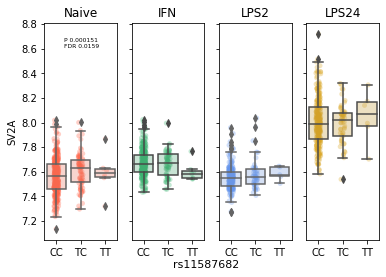

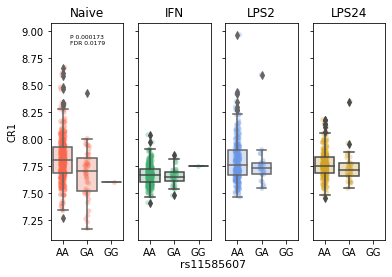

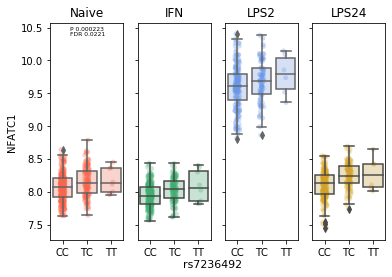

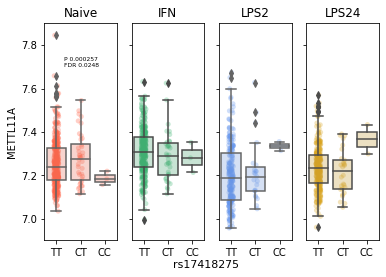

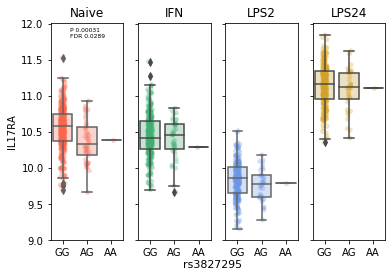

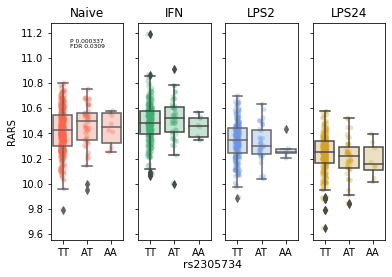

In [6]:
# eQTL plots for Naive group
missing_genes = {}
missing_genes['Naive'] = []
for gene, snp in zip(naive.Gene, naive.ID):

    # Gene's array address
    if gene in expr_info.Symbol.values:
        array_address = expr_info[expr_info.Symbol == gene].index.values[0]

        # Get the genotypes for the individuals
        geno_all = {}
        for locus, row in zip(locus_list, plink_file):
            if snp == locus.name:
                a1 = locus.allele1
                a2 = locus.allele2
                for sample, genotype in zip(sample_list, row):
                    geno_all[sample.iid] = genotype

        for item in geno_all:
            if geno_all[item] > 2:
                geno_all[item] = float('nan')

        # Match them to genotype
        genotypes = []
        samples = {}
        for i in range(3):
            genotypes.append(str(i))
            samples[str(i)] = []

        for key, value in geno_all.items():
            if not isnan(value):
                temp = samples[str(int(value))]
                temp.append(key)
                samples[str(int(value))] = temp
        samples[a1 + a1] = samples.pop('0')
        samples[a1 + a2] = samples.pop('1')
        samples[a2 + a2] = samples.pop('2')

        # Cross expression of the gene with each combination of alleles
        expr_naive = {}
        expr_ifn = {}
        expr_lps2h = {}
        expr_lps24h = {}
        for geno in samples:
            temp_naive = []
            temp_ifn = []
            temp_lps2h = []
            temp_lps24h = []
            for samp in samples[geno]:
                if samp in expr_Naive.columns.values:
                    temp_naive.append(expr_Naive.loc[array_address, samp])
                if samp in expr_IFN.columns.values:
                    temp_ifn.append(expr_IFN.loc[array_address, samp])
                if samp in expr_LPS2.columns.values:
                    temp_lps2h.append(expr_LPS2.loc[array_address, samp])
                if samp in expr_LPS24.columns.values:
                    temp_lps24h.append(expr_LPS24.loc[array_address, samp])
            expr_naive[geno] = temp_naive
            expr_ifn[geno] = temp_ifn
            expr_lps2h[geno] = temp_lps2h
            expr_lps24h[geno] = temp_lps24h

        # Build dataframe
        naive_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_naive.items() if len(v) > 0]))
        naive_df = pd.melt(naive_df, var_name=snp, value_name=gene)
        naive_df['Context'] = 'Naive'
        ifn_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ifn.items() if len(v) > 0]))
        ifn_df = pd.melt(ifn_df, var_name=snp, value_name=gene)
        ifn_df['Context'] = 'IFN'
        lps2h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps2h.items() if len(v) > 0]))
        lps2h_df = pd.melt(lps2h_df, var_name=snp, value_name=gene)
        lps2h_df['Context'] = 'LPS2'
        lps24h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps24h.items() if len(v) > 0]))
        lps24h_df = pd.melt(lps24h_df, var_name=snp, value_name=gene)
        lps24h_df['Context'] = 'LPS24'
        exp_df = pd.concat([naive_df, ifn_df, lps2h_df, lps24h_df])
        exp_df = exp_df.dropna()

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue', 'goldenrod']
        context = ['Naive', 'IFN', 'LPS2', 'LPS24']
        
        # Order x-axis by homozygous(major), heterozygous, homozygous (minor)
        major_allele = naive.query("ID == @snp and Gene == @gene")['Major'].item()
        if a1 == major_allele:
            order = [a1 + a1, a1 + a2, a2 + a2]
        else:
            order = [a2 + a2, a1 + a2, a1 + a1]
           
        # Get eQTL p-value and FDR
        p_value = format(naive.query("ID == @snp and Gene == @gene")['p.value'].item(), '.3g')
        FDR = format(naive.query("ID == @snp and Gene == @gene")['FDR'].item(), '.3g')

        fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3)) # Set boxplot transparency
            ax.set_title(grp)
            ax.set_xlabel('') # Remove x-axis label
            if i > 0:
                ax.set_ylabel('') # Remove repeated y-axis label
                
        # Annotate p-value & FDR
        xmin, xmax, ymin, ymax = plt.axis()
        axes[0].text(0.3, ymax - 0.2, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)
        
        # Add overall x-axis label
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11) 
        
        plt.show()
        
        # Label plots for eQTLs with p < 10e-8 with 'p'
        if float(p_value) < 10e-8:
            fig.savefig('fairfax/figs/Naive/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('fairfax/figs/Naive/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found in expression_info.csv
    else:
        missing_genes['Naive'].append((gene, snp))

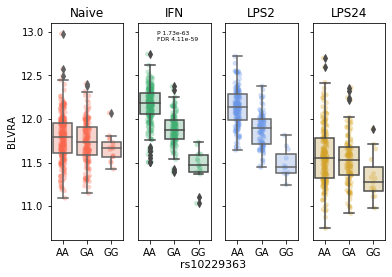

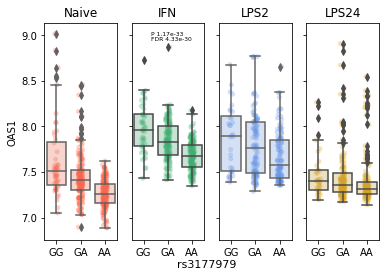

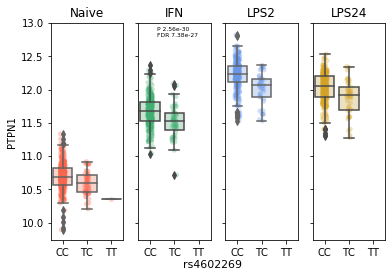

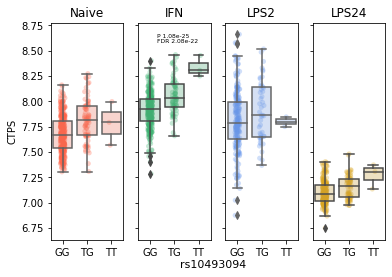

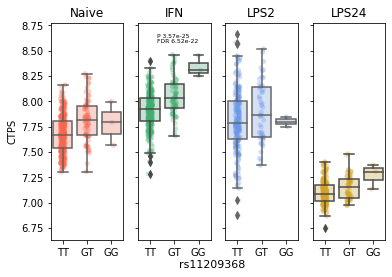

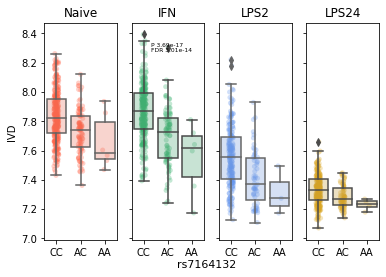

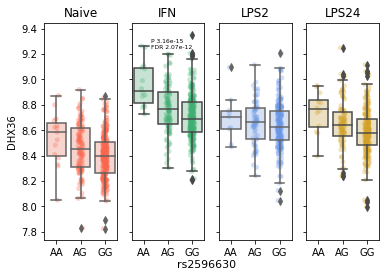

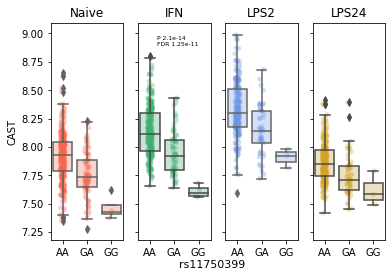

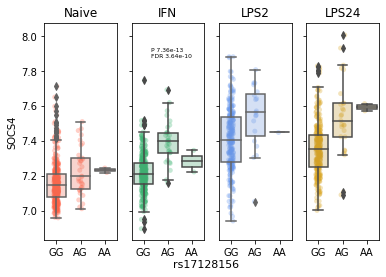

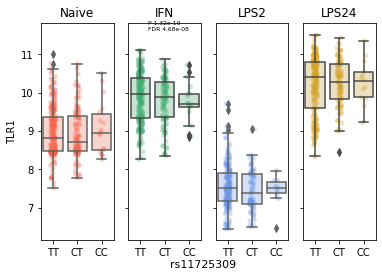

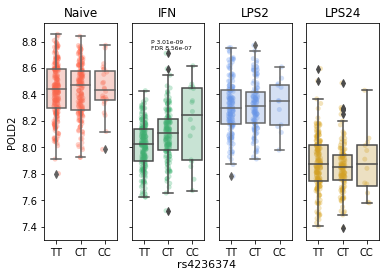

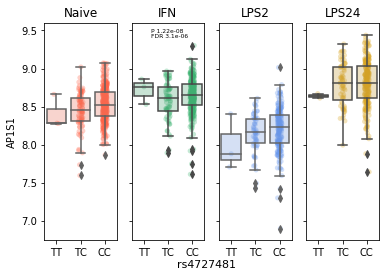

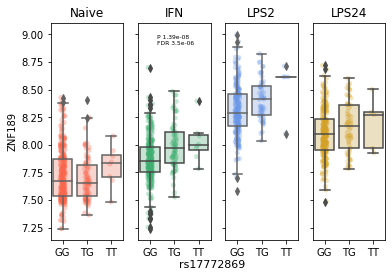

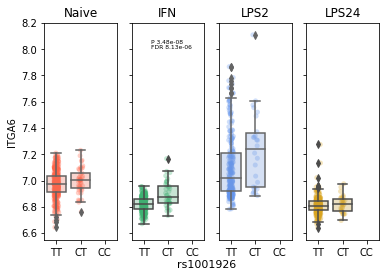

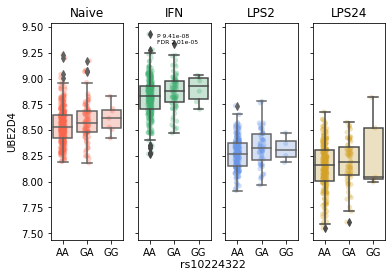

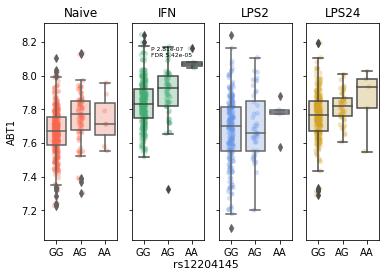

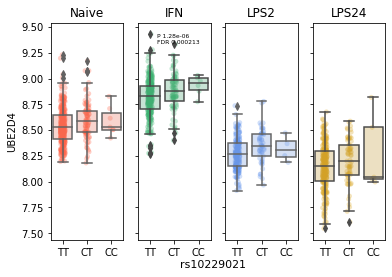

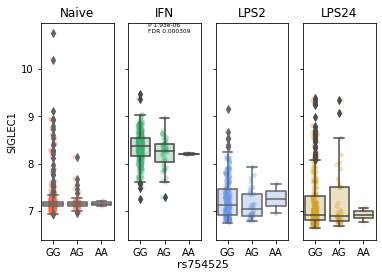

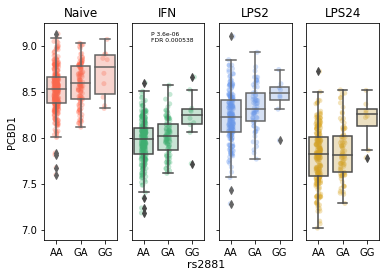

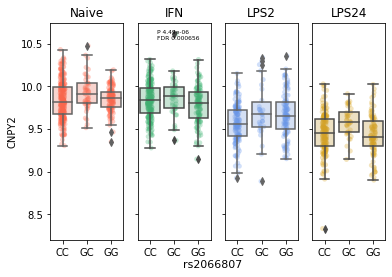

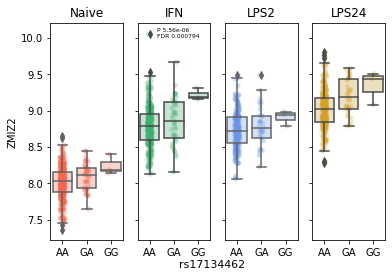

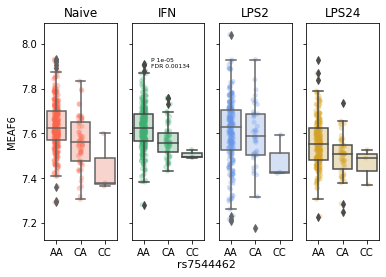

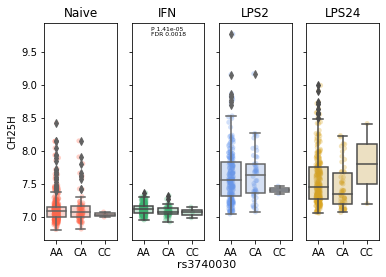

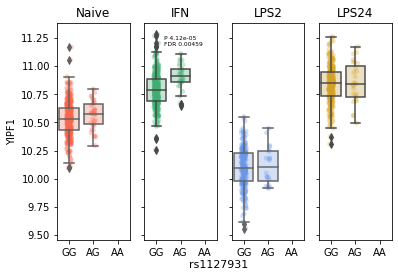

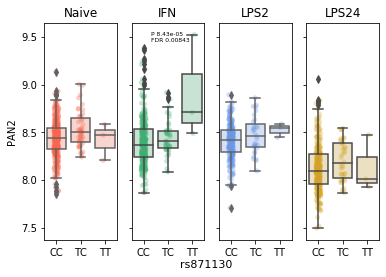

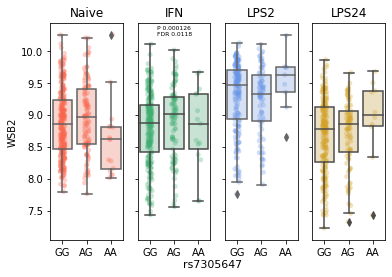

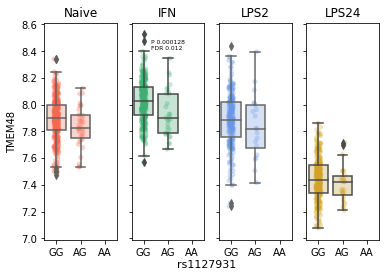

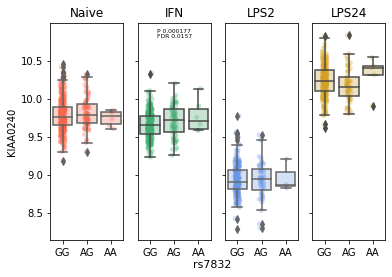

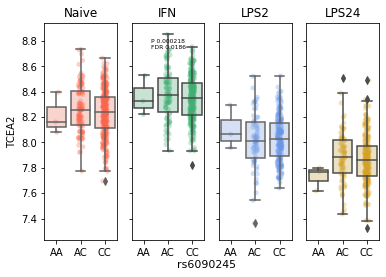

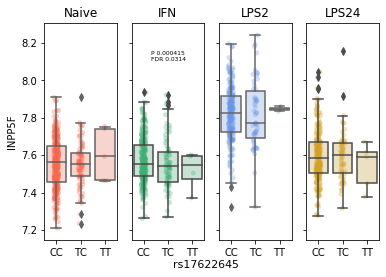

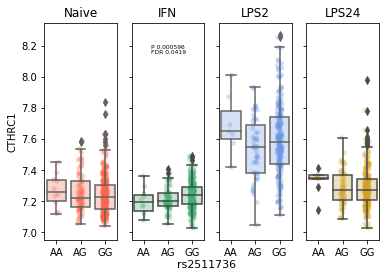

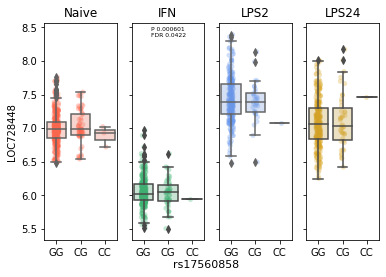

In [7]:
# eQTL plots for IFN group
missing_genes['IFN'] = []
for gene, snp in zip(ifn.Gene, ifn.ID):

    # Gene's array address
    if gene in expr_info.Symbol.values:
        array_address = expr_info[expr_info.Symbol == gene].index.values[0]

        # Get the genotypes for the individuals
        geno_all = {}
        for locus, row in zip(locus_list, plink_file):
            if snp == locus.name:
                a1 = locus.allele1
                a2 = locus.allele2
                for sample, genotype in zip(sample_list, row):
                    geno_all[sample.iid] = genotype

        for item in geno_all:
            if geno_all[item] > 2:
                geno_all[item] = float('nan')

        # Match them to genotype
        genotypes = []
        samples = {}
        for i in range(3):
            genotypes.append(str(i))
            samples[str(i)] = []

        for key, value in geno_all.items():
            if not isnan(value):
                temp = samples[str(int(value))]
                temp.append(key)
                samples[str(int(value))] = temp
        samples[a1 + a1] = samples.pop('0')
        samples[a1 + a2] = samples.pop('1')
        samples[a2 + a2] = samples.pop('2')

        # Cross expression of the gene with each combination of alleles
        expr_naive = {}
        expr_ifn = {}
        expr_lps2h = {}
        expr_lps24h = {}
        for geno in samples:
            temp_naive = []
            temp_ifn = []
            temp_lps2h = []
            temp_lps24h = []
            for samp in samples[geno]:
                if samp in expr_Naive.columns.values:
                    temp_naive.append(expr_Naive.loc[array_address, samp])
                if samp in expr_IFN.columns.values:
                    temp_ifn.append(expr_IFN.loc[array_address, samp])
                if samp in expr_LPS2.columns.values:
                    temp_lps2h.append(expr_LPS2.loc[array_address, samp])
                if samp in expr_LPS24.columns.values:
                    temp_lps24h.append(expr_LPS24.loc[array_address, samp])
            expr_naive[geno] = temp_naive
            expr_ifn[geno] = temp_ifn
            expr_lps2h[geno] = temp_lps2h
            expr_lps24h[geno] = temp_lps24h

        # Build dataframe
        naive_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_naive.items() if len(v) > 0]))
        naive_df = pd.melt(naive_df, var_name=snp, value_name=gene)
        naive_df['Context'] = 'Naive'
        ifn_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ifn.items() if len(v) > 0]))
        ifn_df = pd.melt(ifn_df, var_name=snp, value_name=gene)
        ifn_df['Context'] = 'IFN'
        lps2h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps2h.items() if len(v) > 0]))
        lps2h_df = pd.melt(lps2h_df, var_name=snp, value_name=gene)
        lps2h_df['Context'] = 'LPS2'
        lps24h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps24h.items() if len(v) > 0]))
        lps24h_df = pd.melt(lps24h_df, var_name=snp, value_name=gene)
        lps24h_df['Context'] = 'LPS24'
        exp_df = pd.concat([naive_df, ifn_df, lps2h_df, lps24h_df])
        exp_df = exp_df.dropna()

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue', 'goldenrod']
        context = ['Naive', 'IFN', 'LPS2', 'LPS24']
        
        # Order x-axis by homozygous(major), heterozygous, homozygous (minor)
        major_allele = ifn.query("ID == @snp and Gene == @gene")['Major'].item()
        if a1 == major_allele:
            order = [a1 + a1, a1 + a2, a2 + a2]
        else:
            order = [a2 + a2, a1 + a2, a1 + a1]
           
        # Get eQTL p-value and FDR
        p_value = format(ifn.query("ID == @snp and Gene == @gene")['p.value'].item(), '.3g')
        FDR = format(ifn.query("ID == @snp and Gene == @gene")['FDR'].item(), '.3g')

        fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3)) # Set boxplot transparency
            ax.set_title(grp)
            ax.set_xlabel('') # Remove x-axis label
            if i > 0:
                ax.set_ylabel('') # Remove repeated y-axis label
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11) # Add overall x-axis label
                
        # Annotate p-value & FDR
        xmin, xmax, ymin, ymax = plt.axis()
        axes[1].text(0.3, ymax - 0.2, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)
        
        plt.show()
        
        # Label plots for eQTLs with p < 10e-8 with 'p'
        if float(p_value) < 10e-8:
            fig.savefig('fairfax/figs/IFN/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('fairfax/figs/IFN/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found in expression_info.csv
    else:
        missing_genes['IFN'].append((gene, snp))

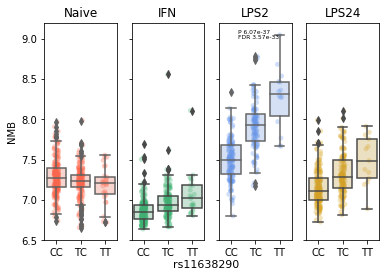

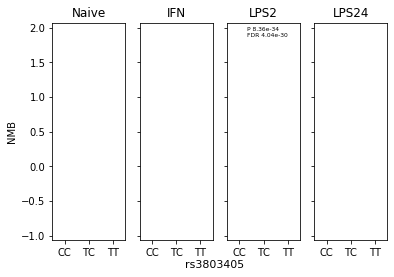

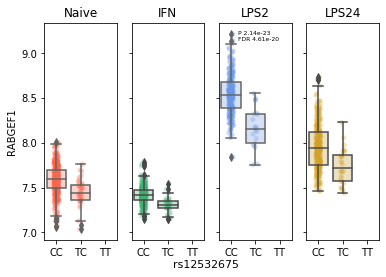

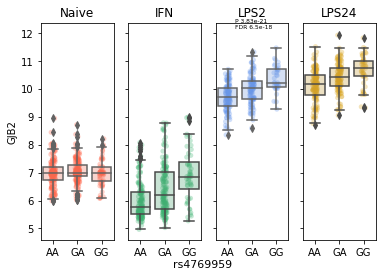

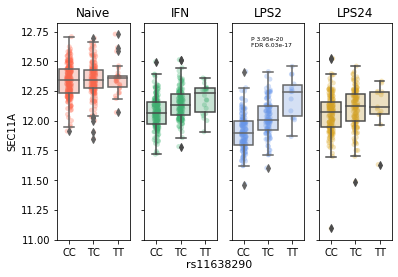

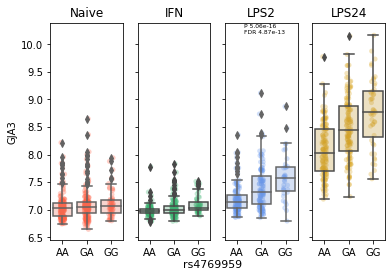

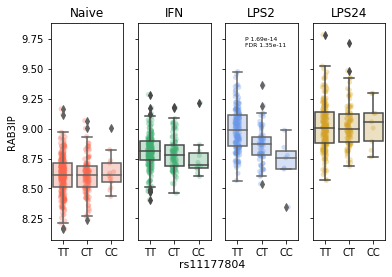

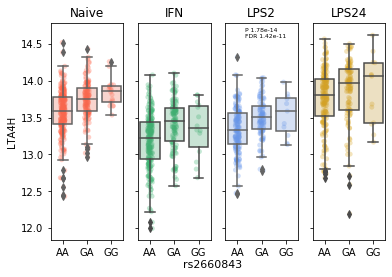

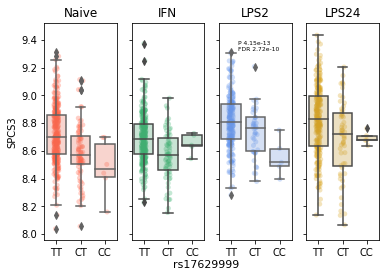

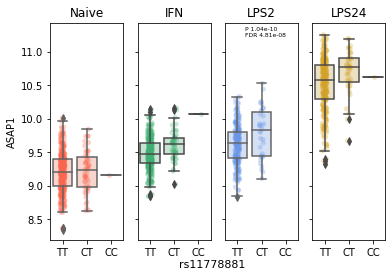

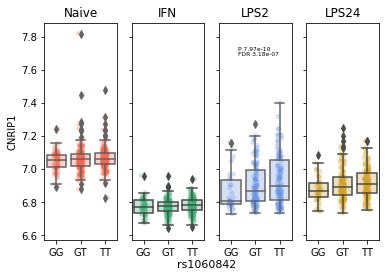

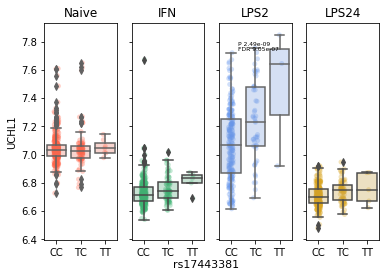

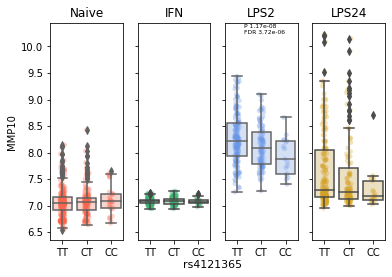

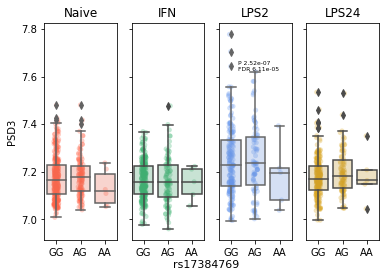

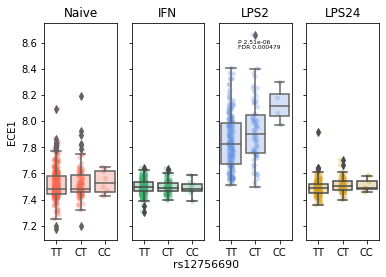

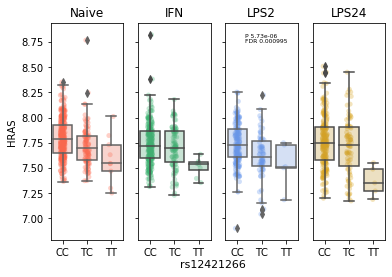

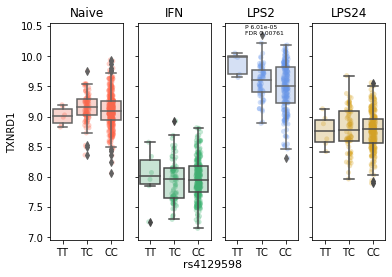

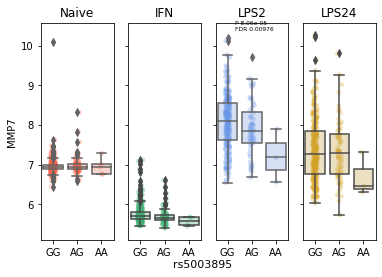

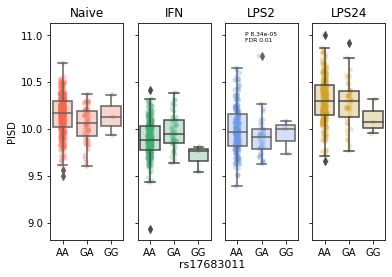

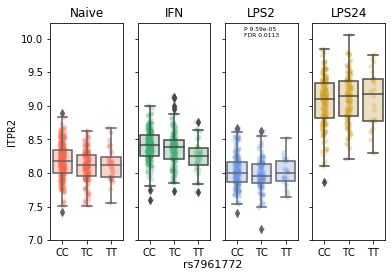

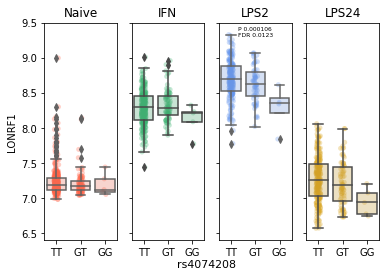

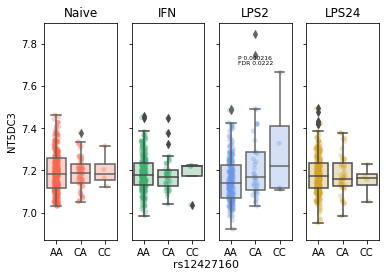

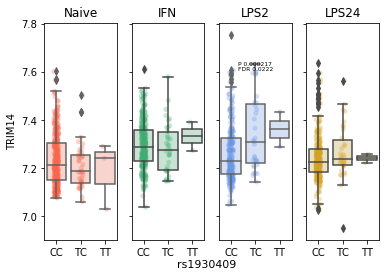

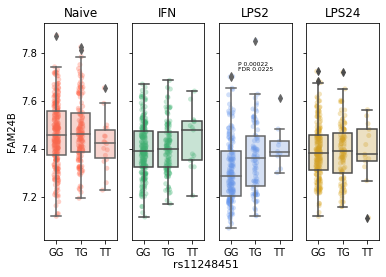

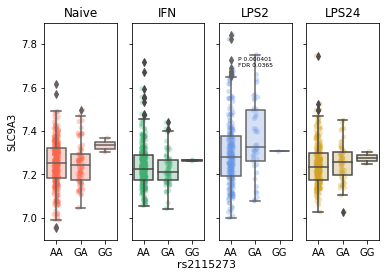

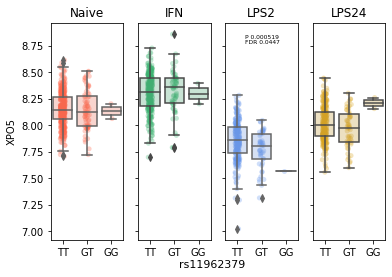

In [8]:
# eQTL plots for LPS2 group
missing_genes['LPS2'] = []
for gene, snp in zip(lps2.Gene, lps2.ID):

    # Gene's array address
    if gene in expr_info.Symbol.values:
        array_address = expr_info[expr_info.Symbol == gene].index.values[0]

        # Get the genotypes for the individuals
        geno_all = {}
        for locus, row in zip(locus_list, plink_file):
            if snp == locus.name:
                a1 = locus.allele1
                a2 = locus.allele2
                for sample, genotype in zip(sample_list, row):
                    geno_all[sample.iid] = genotype

        for item in geno_all:
            if geno_all[item] > 2:
                geno_all[item] = float('nan')

        # Match them to genotype
        genotypes = []
        samples = {}
        for i in range(3):
            genotypes.append(str(i))
            samples[str(i)] = []

        for key, value in geno_all.items():
            if not isnan(value):
                temp = samples[str(int(value))]
                temp.append(key)
                samples[str(int(value))] = temp
        samples[a1 + a1] = samples.pop('0')
        samples[a1 + a2] = samples.pop('1')
        samples[a2 + a2] = samples.pop('2')

        # Cross expression of the gene with each combination of alleles
        expr_naive = {}
        expr_ifn = {}
        expr_lps2h = {}
        expr_lps24h = {}
        for geno in samples:
            temp_naive = []
            temp_ifn = []
            temp_lps2h = []
            temp_lps24h = []
            for samp in samples[geno]:
                if samp in expr_Naive.columns.values:
                    temp_naive.append(expr_Naive.loc[array_address, samp])
                if samp in expr_IFN.columns.values:
                    temp_ifn.append(expr_IFN.loc[array_address, samp])
                if samp in expr_LPS2.columns.values:
                    temp_lps2h.append(expr_LPS2.loc[array_address, samp])
                if samp in expr_LPS24.columns.values:
                    temp_lps24h.append(expr_LPS24.loc[array_address, samp])
            expr_naive[geno] = temp_naive
            expr_ifn[geno] = temp_ifn
            expr_lps2h[geno] = temp_lps2h
            expr_lps24h[geno] = temp_lps24h

        # Build dataframe
        naive_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_naive.items() if len(v) > 0]))
        naive_df = pd.melt(naive_df, var_name=snp, value_name=gene)
        naive_df['Context'] = 'Naive'
        ifn_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ifn.items() if len(v) > 0]))
        ifn_df = pd.melt(ifn_df, var_name=snp, value_name=gene)
        ifn_df['Context'] = 'IFN'
        lps2h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps2h.items() if len(v) > 0]))
        lps2h_df = pd.melt(lps2h_df, var_name=snp, value_name=gene)
        lps2h_df['Context'] = 'LPS2'
        lps24h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps24h.items() if len(v) > 0]))
        lps24h_df = pd.melt(lps24h_df, var_name=snp, value_name=gene)
        lps24h_df['Context'] = 'LPS24'
        exp_df = pd.concat([naive_df, ifn_df, lps2h_df, lps24h_df])
        exp_df = exp_df.dropna()

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue', 'goldenrod']
        context = ['Naive', 'IFN', 'LPS2', 'LPS24']
        
        # Order x-axis by homozygous(major), heterozygous, homozygous (minor)
        major_allele = lps2.query("ID == @snp and Gene == @gene")['Major'].item()
        if a1 == major_allele:
            order = [a1 + a1, a1 + a2, a2 + a2]
        else:
            order = [a2 + a2, a1 + a2, a1 + a1]
           
        # Get eQTL p-value and FDR
        p_value = format(lps2.query("ID == @snp and Gene == @gene")['p.value'].item(), '.3g')
        FDR = format(lps2.query("ID == @snp and Gene == @gene")['FDR'].item(), '.3g')

        fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3)) # Set boxplot transparency
            ax.set_title(grp)
            ax.set_xlabel('') # Remove x-axis label
            if i > 0:
                ax.set_ylabel('') # Remove repeated y-axis label
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11) # Add overall x-axis label
                
        # Annotate p-value & FDR
        xmin, xmax, ymin, ymax = plt.axis()
        axes[2].text(0.3, ymax - 0.2, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)
        
        plt.show()
        
        # Label plots for eQTLs with p < 10e-8 with 'p'
        if float(p_value) < 10e-8:
            fig.savefig('fairfax/figs/LPS2/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('fairfax/figs/LPS2/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found in expression_info.csv
    else:
        missing_genes['LPS2'].append((gene, snp))

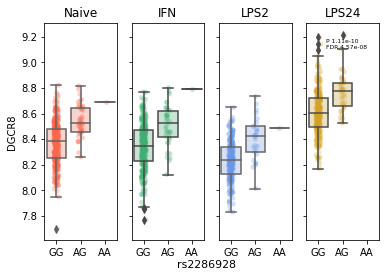

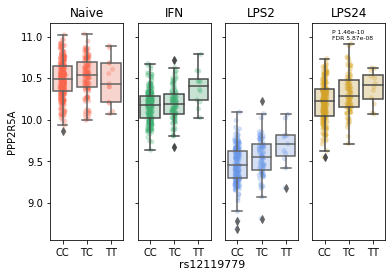

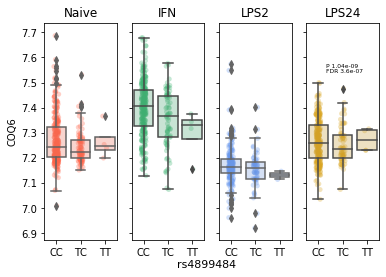

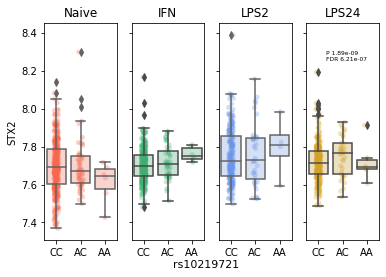

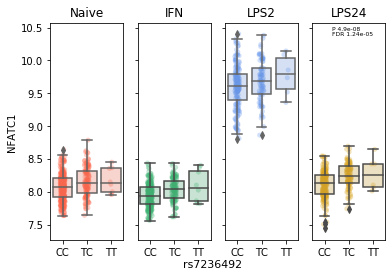

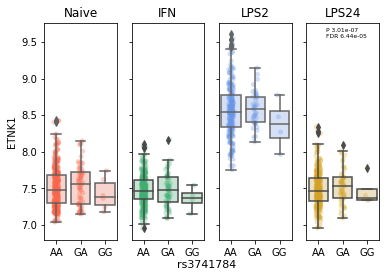

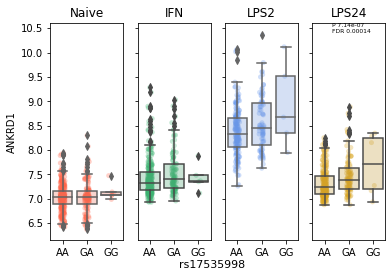

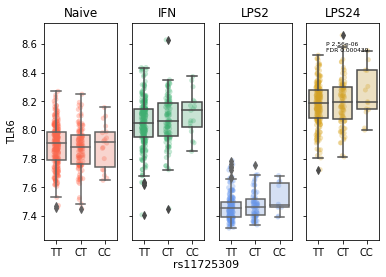

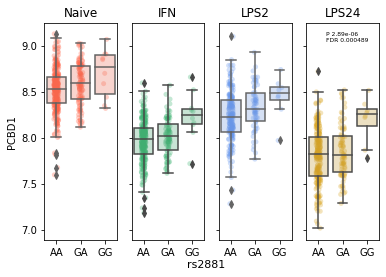

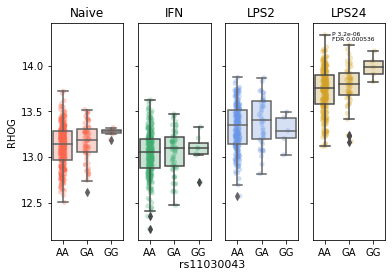

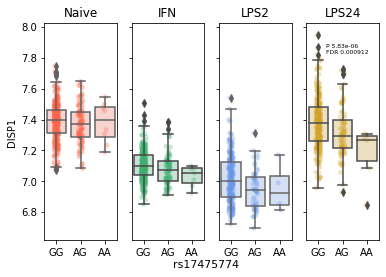

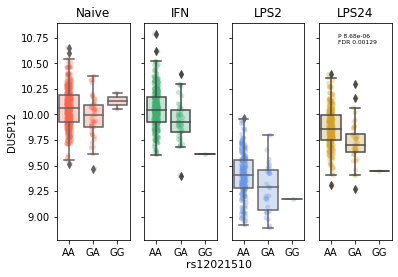

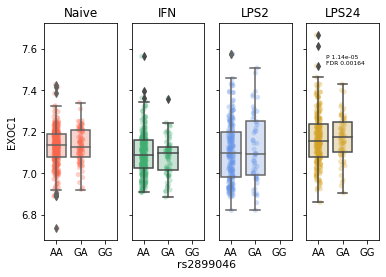

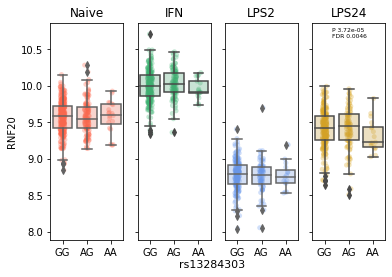

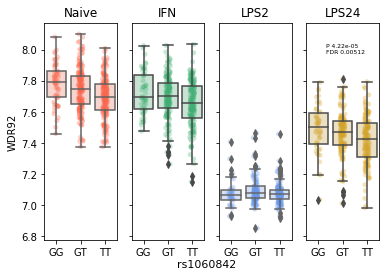

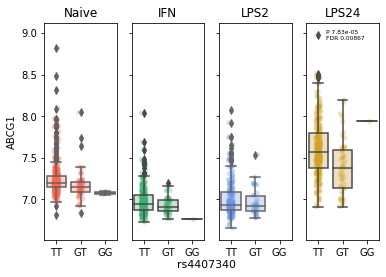

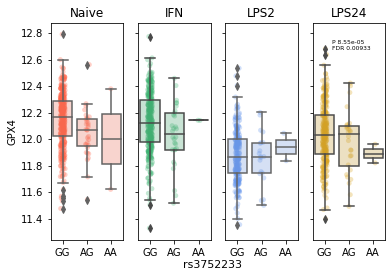

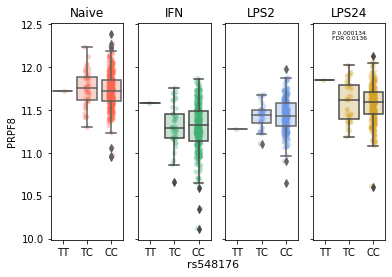

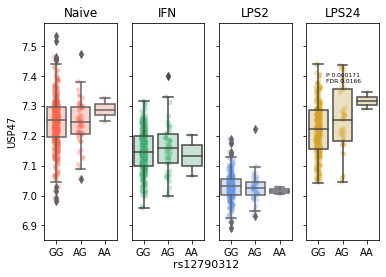

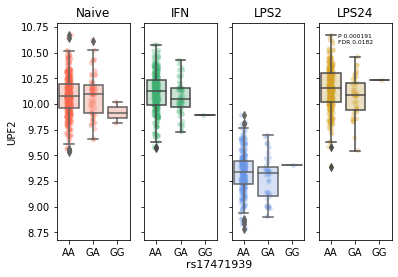

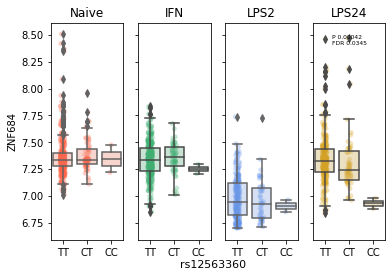

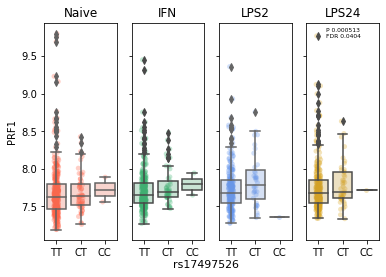

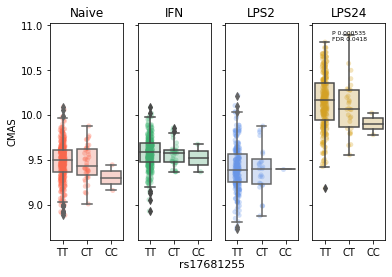

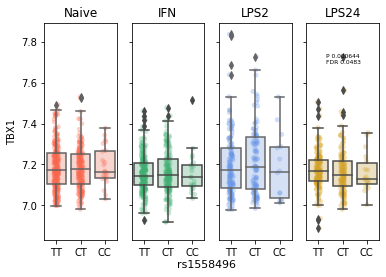

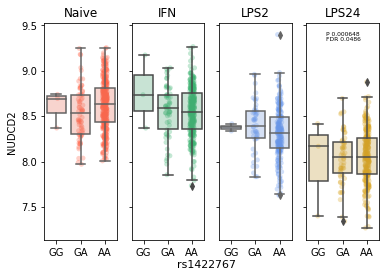

In [9]:
# eQTL plots for LPS2 group
missing_genes['LPS24'] = []
for gene, snp in zip(lps24.Gene, lps24.ID):

    # Gene's array address
    if gene in expr_info.Symbol.values:
        array_address = expr_info[expr_info.Symbol == gene].index.values[0]

        # Get the genotypes for the individuals
        geno_all = {}
        for locus, row in zip(locus_list, plink_file):
            if snp == locus.name:
                a1 = locus.allele1
                a2 = locus.allele2
                for sample, genotype in zip(sample_list, row):
                    geno_all[sample.iid] = genotype

        for item in geno_all:
            if geno_all[item] > 2:
                geno_all[item] = float('nan')

        # Match them to genotype
        genotypes = []
        samples = {}
        for i in range(3):
            genotypes.append(str(i))
            samples[str(i)] = []

        for key, value in geno_all.items():
            if not isnan(value):
                temp = samples[str(int(value))]
                temp.append(key)
                samples[str(int(value))] = temp
        samples[a1 + a1] = samples.pop('0')
        samples[a1 + a2] = samples.pop('1')
        samples[a2 + a2] = samples.pop('2')

        # Cross expression of the gene with each combination of alleles
        expr_naive = {}
        expr_ifn = {}
        expr_lps2h = {}
        expr_lps24h = {}
        for geno in samples:
            temp_naive = []
            temp_ifn = []
            temp_lps2h = []
            temp_lps24h = []
            for samp in samples[geno]:
                if samp in expr_Naive.columns.values:
                    temp_naive.append(expr_Naive.loc[array_address, samp])
                if samp in expr_IFN.columns.values:
                    temp_ifn.append(expr_IFN.loc[array_address, samp])
                if samp in expr_LPS2.columns.values:
                    temp_lps2h.append(expr_LPS2.loc[array_address, samp])
                if samp in expr_LPS24.columns.values:
                    temp_lps24h.append(expr_LPS24.loc[array_address, samp])
            expr_naive[geno] = temp_naive
            expr_ifn[geno] = temp_ifn
            expr_lps2h[geno] = temp_lps2h
            expr_lps24h[geno] = temp_lps24h

        # Build dataframe
        naive_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_naive.items() if len(v) > 0]))
        naive_df = pd.melt(naive_df, var_name=snp, value_name=gene)
        naive_df['Context'] = 'Naive'
        ifn_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ifn.items() if len(v) > 0]))
        ifn_df = pd.melt(ifn_df, var_name=snp, value_name=gene)
        ifn_df['Context'] = 'IFN'
        lps2h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps2h.items() if len(v) > 0]))
        lps2h_df = pd.melt(lps2h_df, var_name=snp, value_name=gene)
        lps2h_df['Context'] = 'LPS2'
        lps24h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps24h.items() if len(v) > 0]))
        lps24h_df = pd.melt(lps24h_df, var_name=snp, value_name=gene)
        lps24h_df['Context'] = 'LPS24'
        exp_df = pd.concat([naive_df, ifn_df, lps2h_df, lps24h_df])
        exp_df = exp_df.dropna()

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue', 'goldenrod']
        context = ['Naive', 'IFN', 'LPS2', 'LPS24']
        
        # Order x-axis by homozygous(major), heterozygous, homozygous (minor)
        major_allele = lps24.query("ID == @snp and Gene == @gene")['Major'].item()
        if a1 == major_allele:
            order = [a1 + a1, a1 + a2, a2 + a2]
        else:
            order = [a2 + a2, a1 + a2, a1 + a1]
           
        # Get eQTL p-value and FDR
        p_value = format(lps24.query("ID == @snp and Gene == @gene")['p.value'].item(), '.3g')
        FDR = format(lps24.query("ID == @snp and Gene == @gene")['FDR'].item(), '.3g')

        fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3)) # Set boxplot transparency
            ax.set_title(grp)
            ax.set_xlabel('') # Remove x-axis label
            if i > 0:
                ax.set_ylabel('') # Remove repeated y-axis label
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11) # Add overall x-axis label
                
        # Annotate p-value & FDR
        xmin, xmax, ymin, ymax = plt.axis()
        axes[3].text(0.3, ymax - 0.2, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)
        
        plt.show()
        
        # Label plots for eQTLs with p < 10e-8 with 'p'
        if float(p_value) < 10e-8:
            fig.savefig('fairfax/figs/LPS24/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('fairfax/figs/LPS24/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found in expression_info.csv
    else:
        missing_genes['LPS24'].append((gene, snp))

### Missing genes

In [10]:
# Genes not in expression_info.csv
missing_genes

{'Naive': [('C9ORF10OS', 'rs12552323'),
  ('HS.536748', 'rs12771873'),
  ('HS.135528', 'rs378322'),
  ('MAP2K1IP1', 'rs10516459')],
 'IFN': [('KTELC1', 'rs17203139'),
  ('HS.576633', 'rs7791240'),
  ('C14ORF100', 'rs17834014'),
  ('C20ORF177', 'rs6071243'),
  ('HS.123317', 'rs1460402'),
  ('C12ORF77', 'rs11047880'),
  ('HS.544379', 'rs17078259')],
 'LPS2': [('HS.144925', 'rs4549165')],
 'LPS24': [('C6ORF108', 'rs7832'),
  ('C9ORF23', 'rs11575584'),
  ('TMEM4', 'rs2066807'),
  ('FLJ45248', 'rs2304348'),
  ('LOC644923', 'rs1327535'),
  ('SAP30L', 'rs1353090'),
  ('HS.40289', 'rs12506506')]}

In [11]:
# Load metadata
f = open('HumanHT-12_V4_0_R2_15002873_B').read().splitlines()
probes = False
header = True
expr_info_all_dict = {}
for i, line in enumerate(f):
    if '[Controls]' == line.rstrip():
        probes = False

    elif probes:
        temp = line.split('\t')
        if header:
            header = False

        elif (temp[14] != '') and (temp[18] != '') and (temp[20] != ''):

            tict = {}
            chrom = temp[18].split('|')
            if chrom[0] != 'Un':
                chr = chrom[0].split('_')
                tict['chrom'] = chr[0]
            else:
                tict['chrom'] = '3'
            coord = temp[20].split(' ')
            pos = coord[0].split(':')
            start_end = pos[0].split('-')
            tict['start'] = int(start_end[0])
            tict['end'] = int(start_end[1])
            tict['Symbol'] = temp[11]
            tict['ILMN_Gene'] = temp[3]
            tict['ILMN_Protein'] = temp[13]

            expr_info_all_dict[int(temp[14])] = tict

    elif '[Probes]' == line.rstrip():
        probes = True
        
expr_info_all = pd.DataFrame(expr_info_all_dict)
expr_info_all = expr_info_all.T
expr_info_all.sort_values(by=['chrom', 'start'], inplace=True)
expr_info_all.head()

chrom  start    end        Symbol    ILMN_Gene  ILMN_Protein
70328       1   3071   3120  LOC100132549  ILMN_335760  ILMN_3236325
2650376     1   3756   3805     LOC653635  ILMN_176099  ILMN_1658957
4050743     1   7480   7529     LOC727882  ILMN_174017  ILMN_3236381
1400176     1   7540   7564     LOC642412   ILMN_41694  ILMN_1690846
1450039     1  15884  15933        WASH5P  ILMN_370616  ILMN_3239735

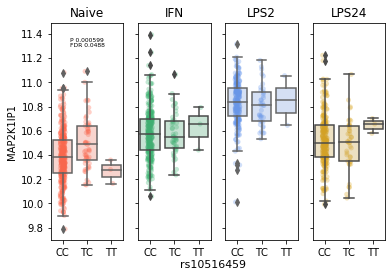

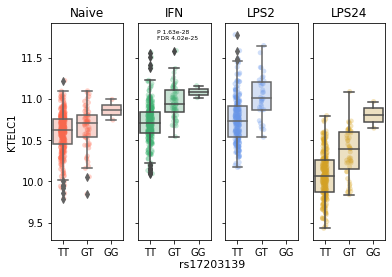

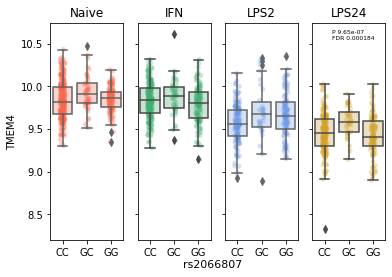

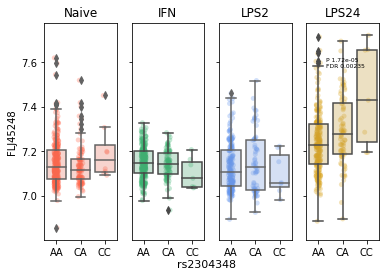

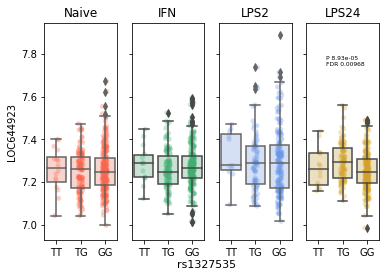

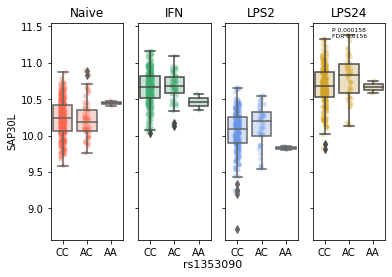

In [12]:
# Check if missing genes are in metadata and plot those that are
missing_meta = []
for grp in missing_genes:
    for gene, snp in missing_genes[grp]:
        if gene in expr_info_all.Symbol.values:
            array_address = expr_info_all[expr_info_all.Symbol == gene].index.values[0]

            # Get the genotypes for the individuals
            geno_all = {}
            for locus, row in zip(locus_list, plink_file):
                if snp == locus.name:
                    a1 = locus.allele1
                    a2 = locus.allele2
                    for sample, genotype in zip(sample_list, row):
                        geno_all[sample.iid] = genotype

            for item in geno_all:
                if geno_all[item] > 2:
                    geno_all[item] = float('nan')

            # Match them to genotype
            genotypes = []
            samples = {}
            for i in range(3):
                genotypes.append(str(i))
                samples[str(i)] = []

            for key, value in geno_all.items():
                if not isnan(value):
                    temp = samples[str(int(value))]
                    temp.append(key)
                    samples[str(int(value))] = temp
            samples[a1 + a1] = samples.pop('0')
            samples[a1 + a2] = samples.pop('1')
            samples[a2 + a2] = samples.pop('2')

            # Cross expression of the gene with each combination of alleles
            expr_naive = {}
            expr_ifn = {}
            expr_lps2h = {}
            expr_lps24h = {}
            for geno in samples:
                temp_naive = []
                temp_ifn = []
                temp_lps2h = []
                temp_lps24h = []
                for samp in samples[geno]:
                    if samp in expr_Naive.columns.values:
                        temp_naive.append(expr_Naive.loc[array_address, samp])
                    if samp in expr_IFN.columns.values:
                        temp_ifn.append(expr_IFN.loc[array_address, samp])
                    if samp in expr_LPS2.columns.values:
                        temp_lps2h.append(expr_LPS2.loc[array_address, samp])
                    if samp in expr_LPS24.columns.values:
                        temp_lps24h.append(expr_LPS24.loc[array_address, samp])
                expr_naive[geno] = temp_naive
                expr_ifn[geno] = temp_ifn
                expr_lps2h[geno] = temp_lps2h
                expr_lps24h[geno] = temp_lps24h

            # Build dataframe
            naive_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_naive.items() if len(v) > 0]))
            naive_df = pd.melt(naive_df, var_name=snp, value_name=gene)
            naive_df['Context'] = 'Naive'
            ifn_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ifn.items() if len(v) > 0]))
            ifn_df = pd.melt(ifn_df, var_name=snp, value_name=gene)
            ifn_df['Context'] = 'IFN'
            lps2h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps2h.items() if len(v) > 0]))
            lps2h_df = pd.melt(lps2h_df, var_name=snp, value_name=gene)
            lps2h_df['Context'] = 'LPS2'
            lps24h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps24h.items() if len(v) > 0]))
            lps24h_df = pd.melt(lps24h_df, var_name=snp, value_name=gene)
            lps24h_df['Context'] = 'LPS24'
            exp_df = pd.concat([naive_df, ifn_df, lps2h_df, lps24h_df])
            exp_df = exp_df.dropna()

            # Plot
            colors = ['tomato', 'mediumseagreen', 'cornflowerblue', 'goldenrod']
            context = ['Naive', 'IFN', 'LPS2', 'LPS24']

            # Order x-axis by homozygous(major), heterozygous, homozygous (minor)
            major_allele = eval(grp.lower()).query("ID == @snp and Gene == @gene")['Major'].item() # eval to access variable from string
            if a1 == major_allele:
                order = [a1 + a1, a1 + a2, a2 + a2]
            else:
                order = [a2 + a2, a1 + a2, a1 + a1]

            # Get eQTL p-value and FDR
            p_value = format(eval(grp.lower()).query("ID == @snp and Gene == @gene")['p.value'].item(), '.3g')
            FDR = format(eval(grp.lower()).query("ID == @snp and Gene == @gene")['FDR'].item(), '.3g')

            fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True)
            for ax in axes:
                i = list(axes).index(ax)
                treatment = context[i]
                f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == treatment], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
                g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == treatment], ax=ax, color=colors[i], order=order)
                for patch in g.artists:
                    r, g, b, a = patch.get_facecolor()
                    patch.set_facecolor((r, g, b, .3)) # Set boxplot transparency
                ax.set_title(treatment)
                ax.set_xlabel('') # Remove x-axis label
                if i > 0:
                    ax.set_ylabel('') # Remove repeated y-axis label
            fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11) # Add overall x-axis label

            # Annotate p-value & FDR
            xmin, xmax, ymin, ymax = plt.axis()
            axes[context.index(grp)].text(0.3, ymax - 0.2, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)

            plt.show()

            # Label plots for eQTLs with p < 10e-8 with 'p'
            if float(p_value) < 10e-8:
                fig.savefig('figs/' + grp + '/p_' + gene + '_' + snp + '_boxplot.pdf')
            else:
                fig.savefig('figs/' + grp + gene + '_' + snp + '_boxplot.pdf')

        # Get genes that could not be found in metadata
        else:
            missing_meta.append((gene, snp))

In [13]:
# Genes not in metadata
missing_meta

[('C9ORF10OS', 'rs12552323'),
 ('HS.536748', 'rs12771873'),
 ('HS.135528', 'rs378322'),
 ('HS.576633', 'rs7791240'),
 ('C14ORF100', 'rs17834014'),
 ('C20ORF177', 'rs6071243'),
 ('HS.123317', 'rs1460402'),
 ('C12ORF77', 'rs11047880'),
 ('HS.544379', 'rs17078259'),
 ('HS.144925', 'rs4549165'),
 ('C6ORF108', 'rs7832'),
 ('C9ORF23', 'rs11575584'),
 ('HS.40289', 'rs12506506')]